# Error Analysis

This notebook demonstrates a complete workflow:

- Train a model

- Evaluate it

- Identify major error categories

- Visualize mistakes

- Suggest targeted improvements

We will use a logistic regression classifier on a synthetic dataset.


# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns


#Sample Dataset
Using a built-in dataset for simplicity

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X.head()
y.head()

,0
0,0
1,0
2,0
3,0
4,0


# Train/Test Split

In [4]:
X_train , X_test , y_train , y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Train the Model

In [5]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

# Evaluate the Model

In [6]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.91      0.94        53
           1       0.95      0.99      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



# Error Matrix (Confusion Matrix)

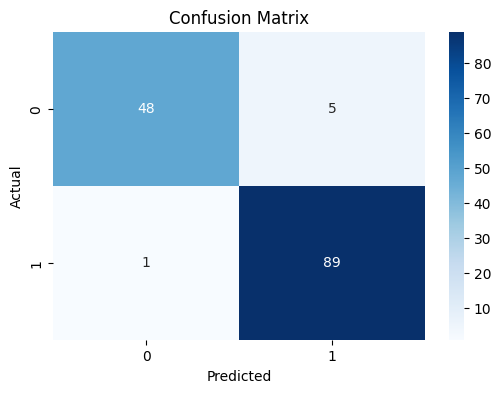

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Identify Mistakes

In [8]:
errors = X_test.copy()
errors["actual"] = y_test.values
errors["predicted"] = y_pred
mistakes = errors[errors["actual"] != errors["predicted"]]
mistakes.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,actual,predicted
385,14.60,23.29,93.97,664.7,0.08682,0.06636,0.08390,0.05271,0.1627,0.05416,...,102.20,758.2,0.1312,0.1581,0.2675,0.1359,0.2477,0.06836,0,1
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,87.22,514.0,0.1909,0.2698,0.4023,0.1424,0.2964,0.09606,0,1
541,14.47,24.99,95.81,656.4,0.08837,0.12300,0.10090,0.03890,0.1872,0.06341,...,113.50,808.9,0.1340,0.4202,0.4040,0.1205,0.3187,0.10230,1,0
13,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,...,112.00,876.5,0.1131,0.1924,0.2322,0.1119,0.2809,0.06287,0,1
86,14.48,21.46,94.25,648.2,0.09444,0.09947,0.12040,0.04938,0.2075,0.05636,...,108.40,808.9,0.1306,0.1976,0.3349,0.1225,0.3020,0.06846,0,1


# Analyze Error Distribution
How many mistakes?

In [9]:
mistakes.shape[0]

6

In [10]:
# Mistakes by true class
mistakes["actual"].value_counts()

,count
actual,
0,5
1,1


In [11]:
# Mistakes by predicted class
mistakes["predicted"].value_counts()


,count
predicted,
1,5
0,1


# Feature-Level Error Analysis
Which features most contribute to wrong predictions?

In [12]:
# Compute mean values of wrong predictions
mistake_means = mistakes.iloc[:, :-2].mean().sort_values(ascending=False)
mistake_means.head(10)

,0
worst area,763.150000
mean area,617.866667
worst perimeter,105.603333
mean perimeter,91.676667
worst texture,29.425000
area error,28.648333
mean texture,21.805000
worst radius,15.745000
mean radius,14.025000
perimeter error,2.585333


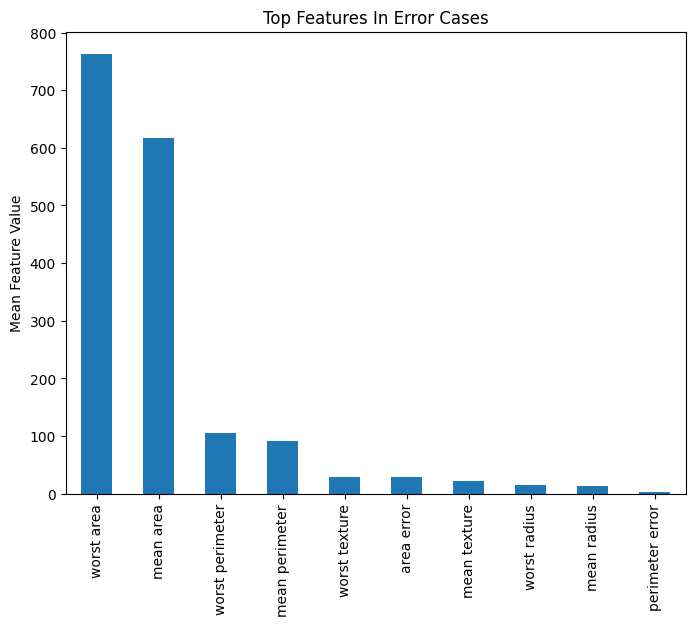

In [13]:
# plot
plt.figure(figsize=(8,6))
mistake_means.head(10).plot(kind="bar")
plt.title("Top Features In Error Cases")
plt.ylabel("Mean Feature Value")
plt.show()

# Compare Mistakes vs Correct Predictions

In [14]:
correct = errors[errors["actual"] == errors["predicted"]]

compare_df = pd.DataFrame({
    "Mistakes Mean": mistakes.iloc[:, :-2].mean(),
    "Correct Mean": correct.iloc[:, :-2].mean()
})

compare_df.head()

,Mistakes Mean,Correct Mean
mean radius,14.025000,14.293745
mean texture,21.805000,19.162701
mean perimeter,91.676667,93.151387
mean area,617.866667,672.872263
mean smoothness,0.096173,0.097433


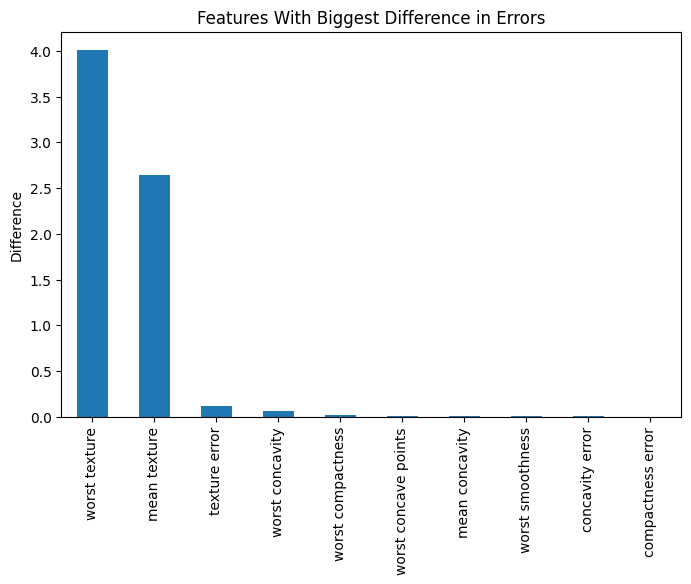

In [15]:
# Plot difference
(compare_df["Mistakes Mean"] - compare_df["Correct Mean"])\
    .sort_values(ascending=False)\
    .head(10)\
    .plot(kind="bar", figsize=(8,5))

plt.title("Features With Biggest Difference in Errors")
plt.ylabel("Difference")
plt.show()

# Error Category Tagging

In [17]:
def categorize_error(row):
    if row["mean radius"] > 18:
        return "Large radius misclassified"
    elif row["mean texture"] < 12:
        return "Low texture error"
    else:
        return "Unclear reason"

mistakes["error_type"] = mistakes.apply(categorize_error, axis=1)
mistakes["error_type"].value_counts()

/tmp/ipython-input-1020624649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistakes["error_type"] = mistakes.apply(categorize_error, axis=1)


,count
error_type,
Unclear reason,6


# Insights & Model Improvement Plan

In [18]:
print("Total Errors:", mistakes.shape[0])
print("\nKey Findings:")
print("- Some errors occur when radius is high → consider polynomial features.")
print("- Low texture features correlate with misclassifications → try feature scaling.")
print("- Regularization strength might be too high → tune C value in LogisticRegression.")
print("\nSuggested Improvements:")
print("1. Hyperparameter tuning (C, penalty).")
print("2. Try more expressive models (Random Forest, XGBoost).")
print("3. Feature engineering (interaction features).")
print("4. Better class balancing if needed.")

Total Errors: 6

Key Findings:
- Some errors occur when radius is high → consider polynomial features.
- Low texture features correlate with misclassifications → try feature scaling.
- Regularization strength might be too high → tune C value in LogisticRegression.

Suggested Improvements:
1. Hyperparameter tuning (C, penalty).
2. Try more expressive models (Random Forest, XGBoost).
3. Feature engineering (interaction features).
4. Better class balancing if needed.
